In [60]:
from gensim.models import Word2Vec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import thor

In [61]:
train = pd.read_csv('../data/total_train.csv')

X = train['title'].str.lower()
y = train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Data Preparation

In [62]:
train_sentences = thor.tokenize(X_train, pattern='\w\w+')
test_sentences =thor.tokenize(X_test, pattern = '\w\w+')

In [63]:
train_sentences.head()

0                [common, signs, of, cervical, cancer]
1    [cubana, chief, priest, hires, rain, makers, t...
2    [geomagnetic, storm, may, have, effectively, d...
3    [masten, wanjala, mob, beats, kenyan, child, s...
4    [astro, founding, member, of, the, reggae, gro...
Name: title, dtype: object

# Word2Vec 

What we will do use a pre-trained Word2Vec model to embed words as 100-dimensional vectors. The model we will use is Stanford's Glove model and we will implement via the NLP library ```gensim```. We have downloaded the pre-trained model in the ```word2vec``` folder. First we will need to convert the glove word2vec model into a gensim word2vec model.

In [64]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = '../word2vec/glove.6B.100d.txt'
word2vec_output_file = '../word2vec/word2vec.txt'

glove2word2vec(glove_input_file, word2vec_output_file)

C:\Users\herma\AppData\Local\Temp\ipykernel_14024\1149461943.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400001, 100)

<br>

With the conversion complete, we can next load the model and test out some of the word embeddings.


In [65]:
#import gensim.downloader as api
#w2v = api.load("glove-wiki-gigaword-100")

from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format('../word2vec/word2vec.txt', binary=False)


<br>

It might be a good idea to demonstrate how a word2vec model actually works. In a nutshell, a word2vec model takes a word such as ```queen``` and maps it to a vector, like so:

In [66]:
w2v['queen']

array([-0.50045 , -0.70826 ,  0.55388 ,  0.673   ,  0.22486 ,  0.60281 ,
       -0.26194 ,  0.73872 , -0.65383 , -0.21606 , -0.33806 ,  0.24498 ,
       -0.51497 ,  0.8568  , -0.37199 , -0.58824 ,  0.30637 , -0.30668 ,
       -0.2187  ,  0.78369 , -0.61944 , -0.54925 ,  0.43067 , -0.027348,
        0.97574 ,  0.46169 ,  0.11486 , -0.99842 ,  1.0661  , -0.20819 ,
        0.53158 ,  0.40922 ,  1.0406  ,  0.24943 ,  0.18709 ,  0.41528 ,
       -0.95408 ,  0.36822 , -0.37948 , -0.6802  , -0.14578 , -0.20113 ,
        0.17113 , -0.55705 ,  0.7191  ,  0.070014, -0.23637 ,  0.49534 ,
        1.1576  , -0.05078 ,  0.25731 , -0.091052,  1.2663  ,  1.1047  ,
       -0.51584 , -2.0033  , -0.64821 ,  0.16417 ,  0.32935 ,  0.048484,
        0.18997 ,  0.66116 ,  0.080882,  0.3364  ,  0.22758 ,  0.1462  ,
       -0.51005 ,  0.63777 ,  0.47299 , -0.3282  ,  0.083899, -0.78547 ,
        0.099148,  0.039176,  0.27893 ,  0.11747 ,  0.57862 ,  0.043639,
       -0.15965 , -0.35304 , -0.048965, -0.32461 , 

<br>

The model converts ```queen``` to a vector by training a neural network. Essentially what the model does is:
- look at the sentences with the word ```queen```.
- For each sentence, mark down all the words that appear near it, e.g. ```prince```, ```mother```, ```highness```, etc. These are called **context words**.
- It then looks for other words with the similar context words such as, eg. ```king``` and adjusts the vector entries for ```queen``` closer to that of ```king```.

The pre-trained model we are using is Stanford's Glove model, which has 6 billion words trained on Wikipedia pages.

Because word2vec transforms words to vectors, we can now add and subtract words like so: if we take ```king``` minus ```man``` plus ```woman```, the resulting vector is closest to ```queen``` (with similarity score of 0.77).

In [67]:
w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.7698541283607483)]

The similarity score between two vectors is measured via the cosine of the angle formed by the two vectors. Intuitively:

<br>

$$\cos(0)=1 \qquad \qquad \cos\left(\frac{\pi}{2}\right)=0$$

<br>

So two vectors which are similar will have small angle $\theta$ and consequently will have a $\cos(\theta)$ near 1. On the other hand two vectors which are "independent" would be nearly orthogonal and hence have nearly $\cos(\theta)$ near 0. 

To compute the cosine of the angle, we can use the Law of Cosines to derive the following formula:
$$\textbf{v}\cdot \textbf{u} = |v||u|\cos(\theta)$$

<br>

$$\cos(\theta)=\frac{\textbf{v}\cdot \textbf{u}}{|v||u|}$$

So the number 0.77 (in the similarity score outputted above) is actually the cosine of the angle between the vector $\textbf{v}$ = ```king``` - ```man``` + ```woman``` and the vectur $\textbf{u}$ = ```queen```. 

In [68]:
v = w2v['king'] - w2v['man'] + w2v['woman']

np.dot(v, w2v['queen'])/(np.linalg.norm(v)*np.linalg.norm(w2v['queen']))

0.7834415

### WARNING

Word2vec is *infamous* for implicitly learning social bias because of how society uses language. One (in)famous example demonstrating gender and sexual bias is the following: ```doctor```-```man```+```woman```

In [69]:
w2v.most_similar(positive = ['doctor', 'woman'], negative=['man'], topn=1)

[('nurse', 0.7735227942466736)]

Notice that word2vec has implicitly learned gender bias since it has associated the word ```woman``` with the occupation of being a ```nurse```. A bit more of an insidious take: word2vec doesn't recognize the existence of woman doctors.

Since we are using Word2Vec for the purposes of extrapolating word "context", it is good to be aware of this rather unfortunate property of Word2Vec. 

Anyways, this is how we will be using Word2Vec:

1. For each document: embed each of the words as a 100-dimensional vector. This gives us an array of 100-D vectors a.k.a. a **tensor**.
2. Concatenate this array into one single very long vector (3000-dimensional to be exact). Now we have transformed our document into a vector but unlike a simple frequency count, the values of the vector correspond to word meaning and word context. We have also preserved word ordering as well.
3. Collect these vectors as rows of a matrix. Now we have a matrix representation of our corpus which we can train a model on.

The hope is that by using word embeddings, we have found a way to encode some semblence of "context" and "meaning". 

In [70]:
# turn each word into a 100-dimensional vector. Words which are not in our vocabulary will have to be encoded as all 0's
def word_to_vector(word):
    try:
        return w2v[word]
    except:
        return np.zeros(100)
    
# turn a document into a chain of 2500-dimensional vector, with each word occupying a slice of size 100.   
def sent_to_vector(sent):
    if len(sent) == 0:
        return np.zeros(3000)
    
    elif len(sent) >= 30:
        return np.concatenate([word_to_vector(word) for word in sent[0:30]])
    
    else:
        n = 30-len(sent)
        return np.concatenate([word_to_vector(word) for word in sent]+[[0]*100]*n)

# turn the corpus into a matrix
def doc_to_vector(ser):
    return [sent_to_vector(sent) for sent in ser]


In [71]:
Xvec_train = doc_to_vector(train_sentences)

Xvec_test = doc_to_vector(test_sentences)

## Logistic Regression

With our corpus properly formatted, let's try to train a model on this and see what happens. With such a high number of training examples and only 3000 input dimensions, Logistic Regression seems like a good first choice.

In [72]:
# logvec = LogisticRegression(max_iter=20_000, C=1)

# logvec.fit(Xvec_train, y_train)

# joblib.dump(logvec, '../models/log2vec.pkl')

logvec = joblib.load('../models/log2vec.pkl')

In [73]:
logvec.score(Xvec_train, y_train), logvec.score(Xvec_test, y_test)

(0.9105759654752683, 0.9051412921697995)

 
Accuracy:  0.9051412921697995
 
Recall:  0.4170755642787046
 
Precision:  0.7166947723440135
 
F1:  0.5272952853598015
 


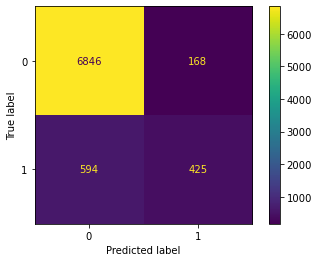

In [74]:
thor.verbose_eval(logvec, Xvec_test, y_test)

In [75]:
ros = RandomOverSampler()

Xover_train, y_over_train = ros.fit_resample(Xvec_train, y_train)

In [76]:
#logvec_over = LogisticRegression(max_iter=20_000, C=1)

#logvec_over.fit(Xover_train, y_over_train)

#joblib.dump(logvec_over, '../models/log2vec_over.pkl')

logvec_over = joblib.load('../models/log2vec_over.pkl')

In [77]:
logvec_over.score(Xover_train, y_over_train), logvec_over.score(Xvec_test, y_test)

(0.8162730282437548, 0.819992530810407)

 
Accuracy:  0.819992530810407
 
Recall:  0.8135426889106968
 
Precision:  0.3976019184652278
 
F1:  0.5341494845360825
 


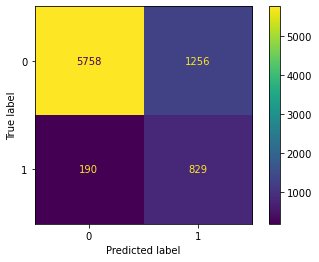

In [78]:
thor.verbose_eval(logvec_over, Xvec_test, y_test)

<br>

Rather interestingly, this model is significantly worse than our previous models using only count frequencies as features. This is rather alarming since we have (at least theoretically) encoded more information for the model to use and yet the model isn't able to use it.

This leads us to suspect that we need a more sophisticated model. 

<br>

# OnionNet: a Simple 1-Layer Neural Network

In [79]:
import tensorflow as tf
from tensorflow import keras

In [80]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [81]:
X_array_train = np.array(Xvec_train)
y_array_train = np.array(y_train)

X_array_test = np.array(Xvec_test)
y_array_test = np.array(y_test)

In [82]:
onionnet = keras.Sequential([
                keras.Input(shape=(3000,)),
                keras.layers.Dense(2000, activation = 'relu', activity_regularizer = keras.regularizers.l2(0.001)),
                keras.layers.Dense(1, activation = 'sigmoid')
            ])

In [83]:
onionnet.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2000)              6002000   
                                                                 
 dense_15 (Dense)            (None, 1)                 2001      
                                                                 
Total params: 6,004,001
Trainable params: 6,004,001
Non-trainable params: 0
_________________________________________________________________


In [84]:
onionnet.compile(
        loss = 'binary_crossentropy',
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        metrics = ['accuracy']
        )

In [85]:
onionnet.fit(X_array_train, y_array_train, epochs = 10, verbose=2, validation_data = (X_array_test, y_array_test))

Epoch 1/10
2260/2260 - 7s - loss: 0.2904 - accuracy: 0.9003 - val_loss: 0.2637 - val_accuracy: 0.9068 - 7s/epoch - 3ms/step
Epoch 2/10
2260/2260 - 7s - loss: 0.2170 - accuracy: 0.9278 - val_loss: 0.2668 - val_accuracy: 0.9111 - 7s/epoch - 3ms/step
Epoch 3/10
2260/2260 - 7s - loss: 0.1498 - accuracy: 0.9563 - val_loss: 0.2821 - val_accuracy: 0.9112 - 7s/epoch - 3ms/step
Epoch 4/10
2260/2260 - 7s - loss: 0.0999 - accuracy: 0.9770 - val_loss: 0.3195 - val_accuracy: 0.9076 - 7s/epoch - 3ms/step
Epoch 5/10
2260/2260 - 7s - loss: 0.0726 - accuracy: 0.9875 - val_loss: 0.3563 - val_accuracy: 0.9004 - 7s/epoch - 3ms/step
Epoch 6/10
2260/2260 - 7s - loss: 0.0624 - accuracy: 0.9903 - val_loss: 0.3850 - val_accuracy: 0.9059 - 7s/epoch - 3ms/step
Epoch 7/10
2260/2260 - 7s - loss: 0.0536 - accuracy: 0.9934 - val_loss: 0.3897 - val_accuracy: 0.9073 - 7s/epoch - 3ms/step
Epoch 8/10
2260/2260 - 7s - loss: 0.0508 - accuracy: 0.9933 - val_loss: 0.4311 - val_accuracy: 0.9045 - 7s/epoch - 3ms/step
Epoch 9/

In [86]:
onionnet.evaluate(X_array_test, y_array_test)

252/252 [==============================] - 1s 3ms/step - loss: 0.4473 - accuracy: 0.9069


[0.44730430841445923, 0.9068840742111206]

In [87]:
probs = pd.Series([p[0] for p in onionnet.predict(X_array_test)])

preds = probs.map(lambda x: 1 if x>=0.5 else 0)

print("Recall: ", recall_score(y_array_test, preds))
print(" ")
print("Precision: ", precision_score(y_array_test, preds))
print(" ")
print("F1: ", f1_score(y_array_test, preds))
print(" ")

Recall:  0.5191364082433758
 
Precision:  0.6721728081321474
 
F1:  0.5858250276854927
 


<br>

We see that accuracy on the test set is 90.8% which is a few tenths of a percentage point better than logistic regression. We suspect that how we've encoded the data is the fundamental issue here.

<br>



<br>

Well, we've thrown everything and the kitchen sink at this data set and we still can't seem to break improve upon the base Logistic Regression model using only count frequencies. This seems to indicate that data itself might just inherently be misbehaving and a bit too dirty. One approach is to find more clean data or to generate a hand-labelled set of simpler training examples.

An alternative approach is to reduce the scope of the problem and try to solve a simpler problem first. For example, we could try instead to classify news articles based on political subreddits which emphasize both a distinct tone as well as distinct keywords.

Another major issue might be the fact that we inherently set-up the problem as one of imbalanced classes. It may be the case that results would be much better if we had set-up the problem where the classes were more balanced. We can check quickly if such a set-up would in fact help.

In [88]:
news_sample_train = train[ train['class'] == 0].iloc[0:10_000]
onion_sample_train = train[ train['class'] == 1].iloc[0:10_000]


balanced_train = pd.concat([news_sample_train, onion_sample_train]).reset_index(drop=True)

X = balanced_train['title']
y = balanced_train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

train_sentences = thor.tokenize(X_train, pattern='\w\w+')
test_sentences =thor.tokenize(X_test, pattern = '\w\w+')

Xvec_train = doc_to_vector(train_sentences)
Xvec_test = doc_to_vector(test_sentences)

X_array_train = np.array(Xvec_train)
y_array_train = np.array(y_train)

X_array_test = np.array(Xvec_test)
y_array_test = np.array(y_test)

In [89]:
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: class, dtype: float64

In [90]:
onionnet2 = keras.Sequential([
                keras.Input(shape=(3000,)),
                keras.layers.Dense(2000, activation = 'relu', activity_regularizer = keras.regularizers.l2(0.0001)),
                keras.layers.Dense(1, activation = 'sigmoid')
            ])

onionnet2.compile(
        loss = 'binary_crossentropy',
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        metrics = ['accuracy']
        )

onionnet2.fit(X_array_train, y_array_train, epochs = 10, verbose=2, validation_data = (X_array_test, y_array_test));

Epoch 1/10
500/500 - 2s - loss: 0.4839 - accuracy: 0.7706 - val_loss: 0.4288 - val_accuracy: 0.7975 - 2s/epoch - 3ms/step
Epoch 2/10
500/500 - 1s - loss: 0.3006 - accuracy: 0.8770 - val_loss: 0.4755 - val_accuracy: 0.7893 - 893ms/epoch - 2ms/step
Epoch 3/10
500/500 - 1s - loss: 0.1460 - accuracy: 0.9517 - val_loss: 0.5052 - val_accuracy: 0.8033 - 894ms/epoch - 2ms/step
Epoch 4/10
500/500 - 1s - loss: 0.0516 - accuracy: 0.9918 - val_loss: 0.5665 - val_accuracy: 0.8048 - 928ms/epoch - 2ms/step
Epoch 5/10
500/500 - 1s - loss: 0.0236 - accuracy: 0.9989 - val_loss: 0.5884 - val_accuracy: 0.8192 - 887ms/epoch - 2ms/step
Epoch 6/10
500/500 - 1s - loss: 0.0178 - accuracy: 0.9991 - val_loss: 0.5797 - val_accuracy: 0.8220 - 891ms/epoch - 2ms/step
Epoch 7/10
500/500 - 1s - loss: 0.0137 - accuracy: 0.9992 - val_loss: 0.5808 - val_accuracy: 0.8195 - 902ms/epoch - 2ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0116 - accuracy: 0.9994 - val_loss: 0.5813 - val_accuracy: 0.8205 - 883ms/epoch - 2ms/step
Epo

In [91]:
probs = pd.Series([p[0] for p in onionnet2.predict(X_array_test)])

preds = probs.map(lambda x: 1 if x>=0.5 else 0)

print("Recall: ", recall_score(y_array_test, preds))
print(" ")
print("Precision: ", precision_score(y_array_test, preds))
print(" ")
print("F1: ", f1_score(y_array_test, preds))
print(" ")

Recall:  0.843
 
Precision:  0.8009501187648456
 
F1:  0.8214372716199756
 


OnionNet performs abut the same as the Random Forest on balanced data. We are lead to believe that the Word2Vec encoding scheme we implemented has some structural flaws that the neural network just cannot over come.




<br>

---

# Conclusion

So it seems that this word2vec encoding of our documents does not work as well as simple frequency encodings from our previous models. This leads us to suggest that there is something inherent in the data (or perhaps in the encoding method) which is preventing a decent model from being trained.

We notice that our neural network seems to reduce training loss at the expense of increasing cross-validation loss. We are currently not sure why this is the case.

---

# Further Investigations

We end our project with a proposal for a possible avenue of future investigation. Recall that the whole premise of using word2vec was to try and preserve word ordering and context clues. Since we are interested in extracting information from word ordering, it might be possible to achieve some better results using a Convolutional Neural Network. Essentially, the idea is to achieve a sort of 3-gram grouping by convolving sequential sub-vectors of length 300 (moving at steps of 100 per word). In the same way that images can be paced-together by convolving sub-matrices of the pixel matrix using a CNN, it might be possible to achieve something analogous to this for a sentence structure.

Another thing worth trying is to run the neural network on the corpus using frequence encoding. Since a basic logistic regression model was abel to do so well using this method, we suspect a neural network may do slightly better and scale better to an even larger data set. At the moment, our hardware limitations prevent us from representing the frequency encoded corpus as a dense matrix, which we would need to do in order to input into the ```keras.Sequential()``` model.